In [6]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from volatility import Panel_GARCH, Panel_GARCH_SLSQP
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from monthdelta import monthdelta
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

In [2]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:]

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

In [3]:
ret_mat = ret_mat.iloc[:, np.where(ret_mat.isna().sum() == 0.0)[0]]

# SLSQP-s optimalizálással, szintén paraméter transzformálással az eredemény:

### $\alpha = 0.4$ és $\beta = 0.4$ kezdeti paraméterekkel, az optimalizálás lefut és  nem ad 0-1 értékű optimalizálást. A threshold-ot sem kell neki beállítani.

In [7]:
mod = Panel_GARCH_SLSQP()
mod.fit(['01', '01'], y * 100)

Loglikelihood:  835.934648213436 

       Parameters  Standard Error  95% CI Lower  95% CI Higher
Alpha    0.054597        0.000016      0.054565       0.054565
Beta     0.933857        0.000022      0.933814       0.933814


# Az LBFGSB optimalizálóval: Az alap beállításunk, hogy $\alpha = 0.4$ és $\beta = 0.4$.

# Threshold nélkül:

In [5]:
model = Panel_GARCH()
model.fit(['01', '01'], y * 100)

Loglikelihood:  868.7140408735379 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  1.323050e-12        0.002486     -0.004873       0.004873
1  1.000000e+00        0.003319      0.993495       1.006505


In [13]:
model.opt

      fun: 868.7140408735379
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 5
     njev: 14
   status: 0
  success: True
        x: array([-27.35108161,  40.69188593])

## Megvizsgáljuk a negatív loglikelihood függvényt az alpha és béta függvényében:

#### Azzal kezdem, hogy egyszerűen kiszámolgatom a loglikelihood függvény értékeit, különböző paraméterek mellett (annyi egyszerűsítéssel, hogy $\alpha + \beta > 1$ esetén 1000-re állítom a loglikelihood értéket és a kiugróan magas loglikelihood függvényeket is szintén 1000-re állítom be)

In [14]:
alpha = np.linspace(1e-6, 1 - 1e-6, 10)
beta = np.linspace(1e-6, 1 - 1e-6, 10)

lls = np.zeros((10, 10))

for i in range(len(alpha)):
    for j in range(len(beta)):
        if alpha[i] + beta[j] > 1.0:
            lls[i][j] = 1000
        else:
            lls[i][j] = model.loglikelihood([alpha[i], beta[j]], y * 100)

lls[np.where(lls >= 1000)] = 1000
best_alpha, best_beta = np.where(lls == np.min(lls))
print('Best alpha parameter: \t', alpha[best_alpha], '\nBest beta parameter: \t', beta[best_beta], '\nLogLikelihood: \t\t', lls[best_alpha][0][best_beta])

Best alpha parameter: 	 [0.11111189] 
Best beta parameter: 	 [0.77777722] 
LogLikelihood: 		 [841.43627924]


## Ábrázolom a negatív loglikelihood felületet:

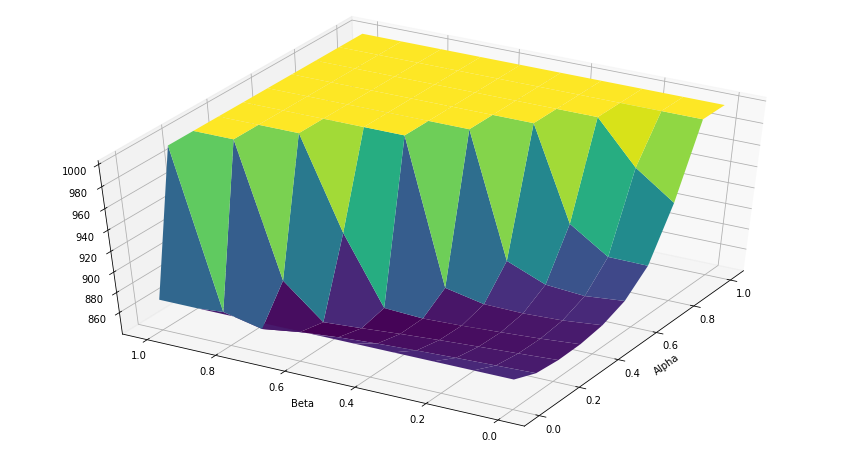

In [19]:
plot_a = np.outer(np.linspace(1e-6, 1 - 1e-6, 10), np.ones(10))
plot_b = plot_a.T

fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
ax.plot_surface(plot_a, plot_b, lls, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.view_init(45, 210)
plt.show()

# Threshold 0.2-re van állítva:

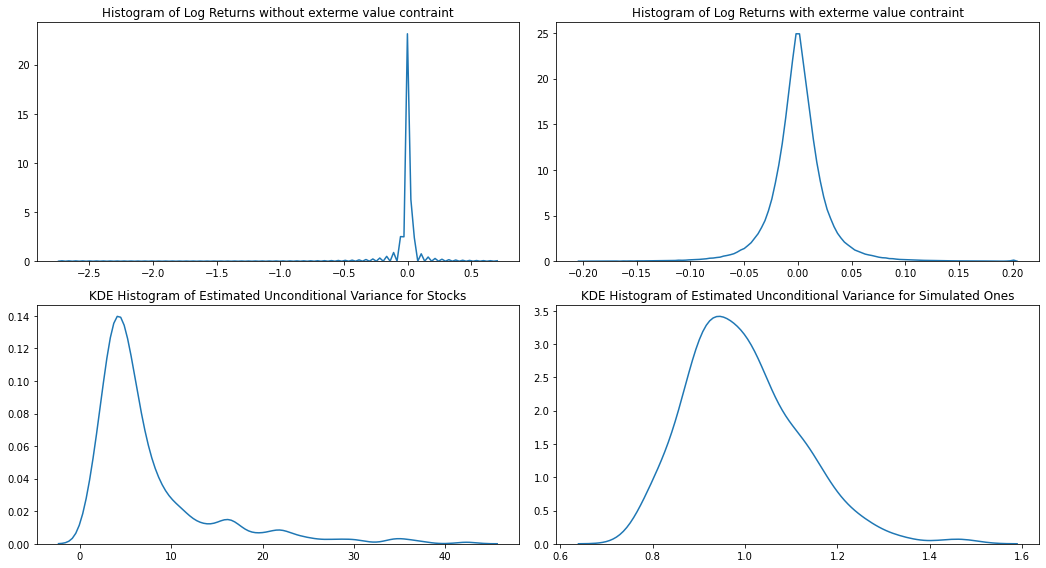

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(1)) & (ret_mat.index < datetime(2005, 1, 1) + monthdelta(1))]

sns.kdeplot(y.stack().values, ax = ax[0][0])
ax[0][0].set_title('Histogram of Log Returns without exterme value contraint')

y_new = y
for j in range(len(y.columns)):
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values >= 0.2)[0], j].values, 0.2) # A 20-nál nagyobb értékeket 20ra állítom
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values <= -0.2)[0], j].values, -0.2) # A -20-nál kisebb értékeket -20ra állítom

sns.kdeplot(y_new.stack().values, ax = ax[0][1])
ax[0][1].set_title('Histogram of Log Returns with exterme value contraint')

sns.kdeplot(np.mean(((y_new * 100) ** 2), axis = 0), ax = ax[1][0])
ax[1][0].set_title('KDE Histogram of Estimated Unconditional Variance for Stocks')

_, r = model.simulate(num = 400, length = 1200)

sns.kdeplot(np.mean((r ** 2), axis = 0), ax = ax[1][1])
ax[1][1].set_title('KDE Histogram of Estimated Unconditional Variance for Simulated Ones')


plt.tight_layout()
plt.show()

In [20]:
model.fit(['01','01'], y_new * 100)

Loglikelihood:  861.5563260568908 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  4.746215e-09        0.007001     -0.013722       0.013722
1  1.000000e+00        0.005506      0.989208       1.010792


In [21]:
model.opt

      fun: 861.5563260568908
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00014779, 0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 3
     njev: 28
   status: 0
  success: True
        x: array([-19.16591832, 109.57913204])

## Nézzük meg, mennyivel változtatja meg az eredményt, ha a threshold-ot 0.2-re állítottuk:

In [22]:
alpha = np.linspace(1e-6, 1 - 1e-6, 10)
beta = np.linspace(1e-6, 1 - 1e-6, 10)

lls = np.zeros((10, 10))

for i in range(len(alpha)):
    for j in range(len(beta)):
        if alpha[i] + beta[j] > 1.0:
            lls[i][j] = 1000
        else:
            lls[i][j] = model.loglikelihood([alpha[i], beta[j]], y_new * 100)

lls[np.where(lls >= 1000)] = 1000
best_alpha, best_beta = np.where(lls == np.min(lls))
print('Best alpha parameter: \t', alpha[best_alpha], '\nBest beta parameter: \t', beta[best_beta], '\nLogLikelihood: \t\t', lls[best_alpha][0][best_beta])

Best alpha parameter: 	 [0.11111189] 
Best beta parameter: 	 [0.77777722] 
LogLikelihood: 		 [834.70608165]


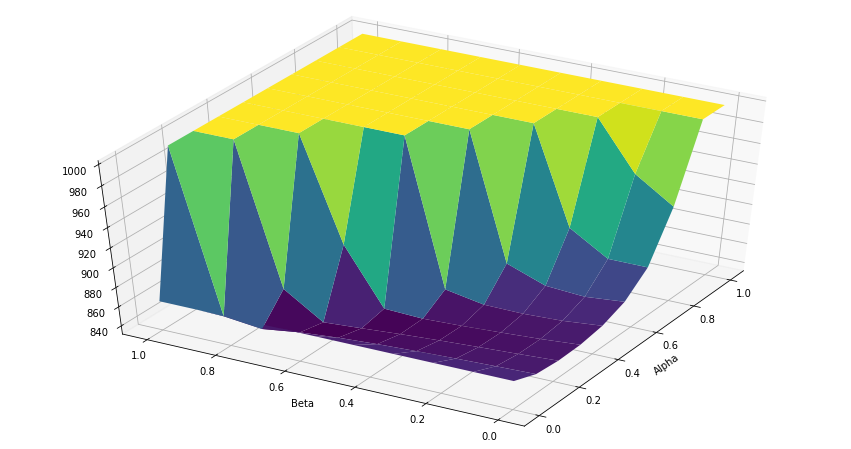

In [23]:
plot_a = np.outer(np.linspace(1e-6, 1 - 1e-6, 10), np.ones(10))
plot_b = plot_a.T

fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
ax.plot_surface(plot_a, plot_b, lls, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.view_init(45, 210)
plt.show()

# Threshold 0.15-re van állítva:

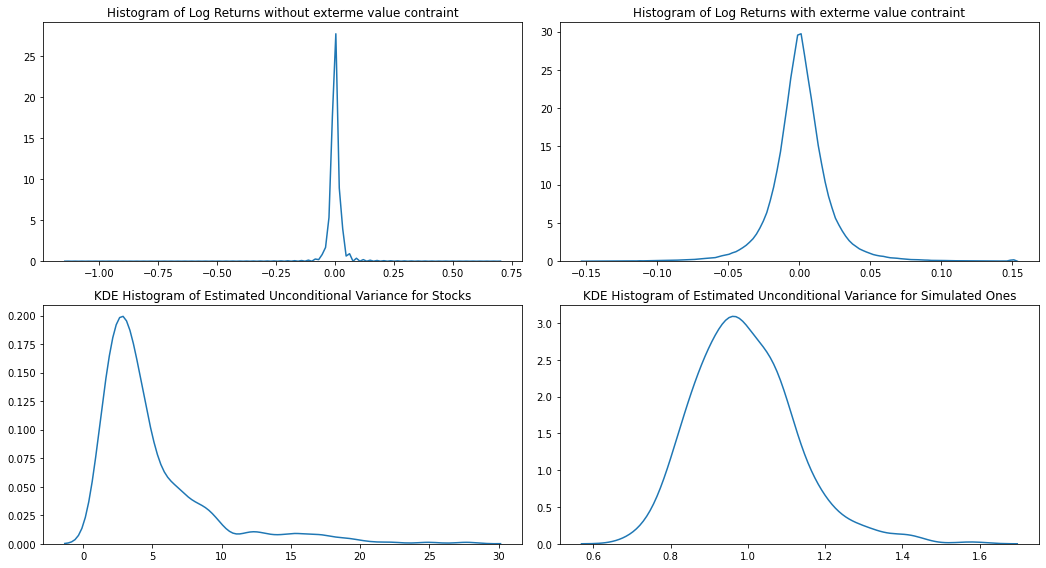

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(16)) & (ret_mat.index < datetime(2005, 1, 1) + monthdelta(16))]

sns.kdeplot(y.stack().values, ax = ax[0][0])
ax[0][0].set_title('Histogram of Log Returns without exterme value contraint')

y_new = y
for j in range(len(y.columns)):
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values >= 0.15)[0], j].values, 0.15) # A 15-nál nagyobb értékeket 15ra állítom
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values <= -0.15)[0], j].values, -0.15) # A -15-nál kisebb értékeket -15ra állítom

sns.kdeplot(y_new.stack().values, ax = ax[0][1])
ax[0][1].set_title('Histogram of Log Returns with exterme value contraint')

sns.kdeplot(np.mean(((y_new * 100) ** 2), axis = 0), ax = ax[1][0])
ax[1][0].set_title('KDE Histogram of Estimated Unconditional Variance for Stocks')

_, r = model.simulate(num = 400, length = 1200)

sns.kdeplot(np.mean((r ** 2), axis = 0), ax = ax[1][1])
ax[1][1].set_title('KDE Histogram of Estimated Unconditional Variance for Simulated Ones')

plt.tight_layout()
plt.show()

In [25]:
model.fit(['01','01'], y_new * 100)

Loglikelihood:  787.0737656952349 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000011        0.007004     -0.013717       0.013739
1    1.000000        0.005508      0.989204       1.010796


In [26]:
model.opt

      fun: 787.0737656952349
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00801492, 0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 3
     njev: 29
   status: 0
  success: True
        x: array([-11.42084391, 390.83657378])

## Nézzük meg, mennyivel változtatja meg az eredményt, ha a threshold-ot 0.15-re állítottuk:

In [27]:
alpha = np.linspace(1e-6, 1 - 1e-6, 10)
beta = np.linspace(1e-6, 1 - 1e-6, 10)

lls = np.zeros((10, 10))

for i in range(len(alpha)):
    for j in range(len(beta)):
        if alpha[i] + beta[j] > 1.0:
            lls[i][j] = 1000
        else:
            lls[i][j] = model.loglikelihood([alpha[i], beta[j]], y_new * 100)

lls[np.where(lls >= 1000)] = 1000
best_alpha, best_beta = np.where(lls == np.min(lls))
print('Best alpha parameter: \t', alpha[best_alpha], '\nBest beta parameter: \t', beta[best_beta], '\nLogLikelihood: \t\t', lls[best_alpha][0][best_beta])

Best alpha parameter: 	 [0.11111189] 
Best beta parameter: 	 [0.77777722] 
LogLikelihood: 		 [762.16608937]


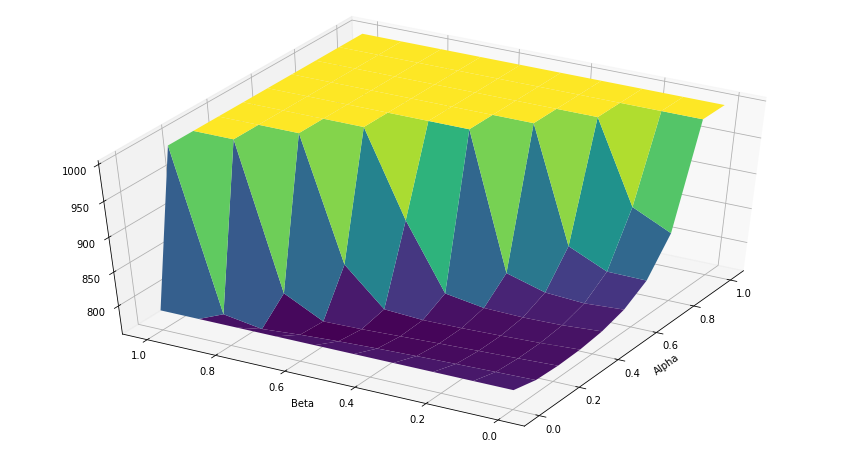

In [28]:
plot_a = np.outer(np.linspace(1e-6, 1 - 1e-6, 10), np.ones(10))
plot_b = plot_a.T

fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
ax.plot_surface(plot_a, plot_b, lls, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.view_init(45, 210)
plt.show()

# Threshold 0.1-re van állítva:

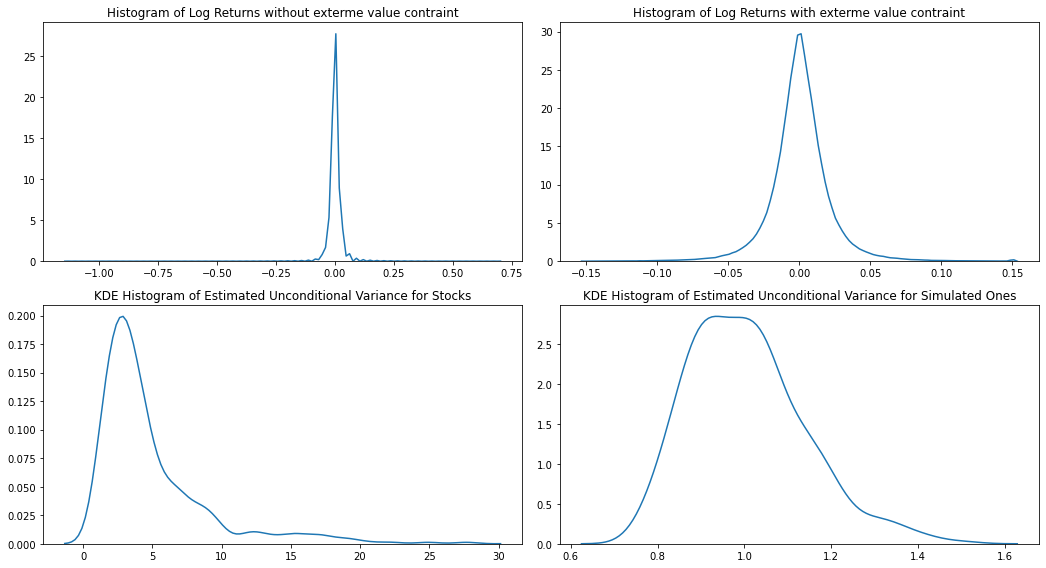

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(16)) & (ret_mat.index < datetime(2005, 1, 1) + monthdelta(16))]

sns.kdeplot(y.stack().values, ax = ax[0][0])
ax[0][0].set_title('Histogram of Log Returns without exterme value contraint')

y_new = y
for j in range(len(y.columns)):
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values >= 0.15)[0], j].values, 0.15) # A 15-nál nagyobb értékeket 15ra állítom
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values <= -0.15)[0], j].values, -0.15) # A -15-nál kisebb értékeket -15ra állítom

sns.kdeplot(y_new.stack().values, ax = ax[0][1])
ax[0][1].set_title('Histogram of Log Returns with exterme value contraint')

sns.kdeplot(np.mean(((y_new * 100) ** 2), axis = 0), ax = ax[1][0])
ax[1][0].set_title('KDE Histogram of Estimated Unconditional Variance for Stocks')

_, r = model.simulate(num = 400, length = 1200)

sns.kdeplot(np.mean((r ** 2), axis = 0), ax = ax[1][1])
ax[1][1].set_title('KDE Histogram of Estimated Unconditional Variance for Simulated Ones')

plt.tight_layout()
plt.show()

In [30]:
model.fit(['01','01'], y_new * 100)

Loglikelihood:  787.0737656952349 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000011        0.007004     -0.013717       0.013739
1    1.000000        0.005508      0.989204       1.010796


In [31]:
model.opt

      fun: 787.0737656952349
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00801492, 0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 3
     njev: 29
   status: 0
  success: True
        x: array([-11.42084391, 390.83657378])

## Nézzük meg, mennyivel változtatja meg az eredményt, ha a threshold-ot 0.1-re állítottuk:

In [32]:
alpha = np.linspace(1e-6, 1 - 1e-6, 10)
beta = np.linspace(1e-6, 1 - 1e-6, 10)

lls = np.zeros((10, 10))

for i in range(len(alpha)):
    for j in range(len(beta)):
        if alpha[i] + beta[j] > 1.0:
            lls[i][j] = 1000
        else:
            lls[i][j] = model.loglikelihood([alpha[i], beta[j]], y_new * 100)

lls[np.where(lls >= 1000)] = 1000
best_alpha, best_beta = np.where(lls == np.min(lls))
print('Best alpha parameter: \t', alpha[best_alpha], '\nBest beta parameter: \t', beta[best_beta], '\nLogLikelihood: \t\t', lls[best_alpha][0][best_beta])

Best alpha parameter: 	 [0.11111189] 
Best beta parameter: 	 [0.77777722] 
LogLikelihood: 		 [762.16608937]


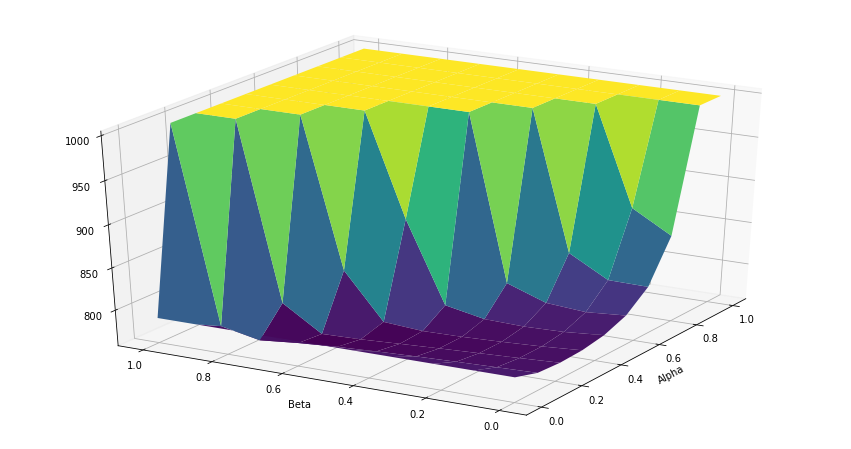

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plot_a = np.outer(np.linspace(1e-6, 1 - 1e-6, 10), np.ones(10))
plot_b = plot_a.T

fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
ax.plot_surface(plot_a, plot_b, lls, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.view_init(30, 210)
plt.show()

# Ha a kezdeti paramétereinket $\alpha = 0.1$ és $\beta = 0.8$-ra választom meg:

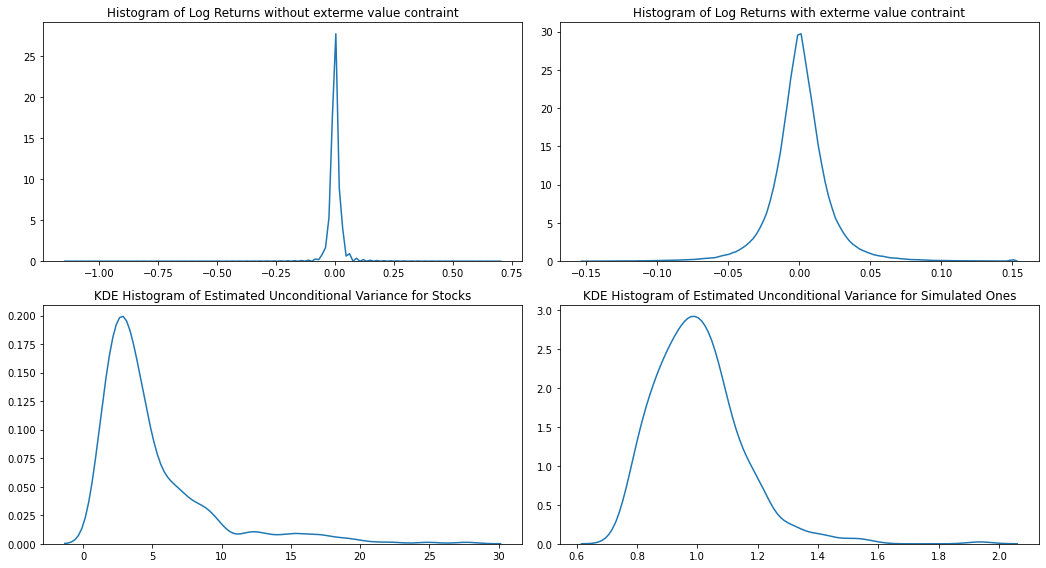

In [5]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(16)) & (ret_mat.index < datetime(2005, 1, 1) + monthdelta(16))]

sns.kdeplot(y.stack().values, ax = ax[0][0])
ax[0][0].set_title('Histogram of Log Returns without exterme value contraint')

y_new = y
for j in range(len(y.columns)):
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values >= 0.15)[0], j].values, 0.15) # A 15-nál nagyobb értékeket 15ra állítom
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values <= -0.15)[0], j].values, -0.15) # A -15-nál kisebb értékeket -15ra állítom

sns.kdeplot(y_new.stack().values, ax = ax[0][1])
ax[0][1].set_title('Histogram of Log Returns with exterme value contraint')

sns.kdeplot(np.mean(((y_new * 100) ** 2), axis = 0), ax = ax[1][0])
ax[1][0].set_title('KDE Histogram of Estimated Unconditional Variance for Stocks')

_, r = model.simulate(num = 400, length = 1200)

sns.kdeplot(np.mean((r ** 2), axis = 0), ax = ax[1][1])
ax[1][1].set_title('KDE Histogram of Estimated Unconditional Variance for Simulated Ones')

plt.tight_layout()
plt.show()

### Threshold nélkül:

#### Ezekkel a kezdőértékekkel le sem fut az optimalizálás

In [6]:
model.fit(['01', '01'], y * 100)

Loglikelihood:  nan 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0         0.1        0.006987      0.086306       0.113694
1         0.8        0.005993      0.788254       0.811746


In [7]:
model.opt

      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.58216259, -8.48424411])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-2.19722458,  1.38629436])

### Threshold = 0.1-gyel:

#### Itt sem fut le ezekkel a kezdeti paraméterekkel

In [9]:
model.fit(['01', '01'], y_new * 100)

Loglikelihood:  nan 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0         0.1        0.006987      0.086306       0.113694
1         0.8        0.005993      0.788254       0.811746


In [10]:
model.opt

      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.9703455 , -8.03681819])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-2.19722458,  1.38629436])

# Ha a kezdeti paramétereinket $\alpha = 0.1$ és $\beta = 0.7$-ra választom meg:

### Először threshold nélkül:

In [6]:
model.fit(['01', '01'], y * 100)

Loglikelihood:  nan 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0         0.1        0.006987      0.086306       0.113694
1         0.7        0.006212      0.687825       0.712175


In [7]:
model.opt

      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09320766, -8.04679981])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-2.19722458,  0.84729786])

### Threshold = 0.1-gyel:

In [8]:
model.fit(['01', '01'], y_new * 100)

Loglikelihood:  nan 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0         0.1        0.006987      0.086306       0.113694
1         0.7        0.006212      0.687825       0.712175


In [9]:
model.opt

      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.67195245, -7.79314174])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-2.19722458,  0.84729786])